In this tutorial, we'll build and train a neural network to classify images of clothing, like sneakers and shirts.

## Install and import dependencies

In [1]:
!pip install -U tensorflow_datasets

     |████████████████████████████████| 4.0 MB 4.5 MB/s eta 0:00:01
     |████████████████████████████████| 48 kB 1.5 MB/s eta 0:00:01
     |████████████████████████████████| 86 kB 2.9 MB/s eta 0:00:011
     |████████████████████████████████| 129 kB 1.9 MB/s eta 0:00:01
     |████████████████████████████████| 207 kB 3.0 MB/s eta 0:00:01
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21494 sha256=0e12befe7784d83e22db4baddb2172e85e389b078ac0acc8852ac3bb133e49f9
  Stored in directory: /Users/ozerozdal/Library/Caches/pip/wheels/54/aa/01/724885182f93150035a2a91bce34a12877e8067a97baaf5dc8
Successfully built promise
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.0.0
    Uninstalling absl-py-1.0.0:
      Successfully uninstalled absl-py-1.0.0


In [2]:
import tensorflow as tf

In [3]:
# Import TensorFlow Datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Import the Fashion MNIST dataset

We will use 60,000 images to train the network and 10,000 images to evaluate how accurately the network learned to classify images.

In [5]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Dataset fashion_mnist downloaded and prepared to /Users/ozerozdal/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


Loading the dataset returns metadata as well as a *training dataset* and *test dataset*.

* The model is trained using `train_dataset`.
* The model is tested against `test_dataset`.

The images are 28 $\times$ 28 arrays, with pixel values in the range `[0, 255]`. The *labels* are an array of integers, in the range `[0, 9]`. These correspond to the *class* of clothing the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [9]:
class_names = metadata.features['label'].names
print("Class names: {}".format(class_names))

Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


### Explore the data

Let's explore the format of the dataset before training the model. The following shows there are 60,000 images in the training set, and 10000 images in the test set:

In [13]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


## Preprocess the data

The value of each pixel in the image data is an integer in the range `[0,255]`. For the model to work properly, these values need to be normalized to the range `[0,1]`. So here we create a normalization function, and then apply it to each image in the test and train datasets.

In [14]:
def normalize(images, labels):
    images = tf.cast(images, tf.float32)
    images /= 255
    return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

### Explore the processed data

Let's plot an image to see what it looks like.

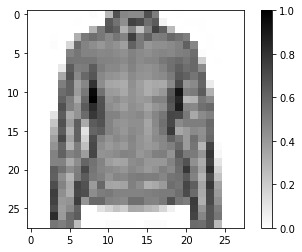

In [18]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
    break
image = image.numpy().reshape((28,28))

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

Display the first 25 images from the training set and display the class name below each image. Verify that the data is in the correct format and we're ready to build and train the network.

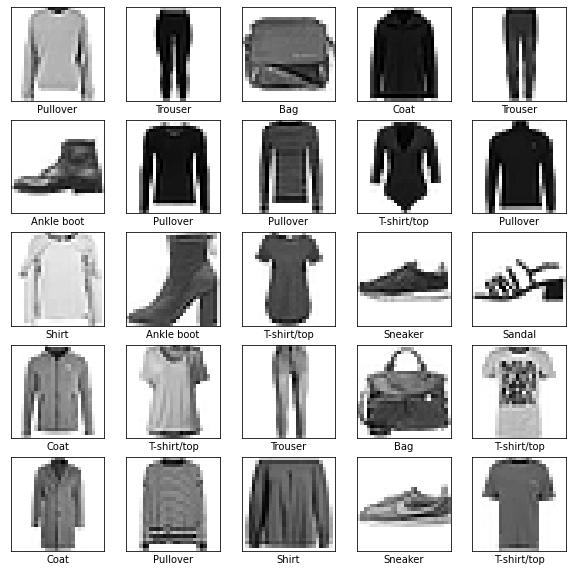

In [31]:
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(train_dataset.take(25)):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
plt.show()